# Fonollosa 2014 — Gas Sensor Array in Turbulent Gas Mixtures

This notebook loads the dataset from [Fonollosa et al. 2014](https://www.mdpi.com/1424-8220/14/10/19336) (UCI ID 309) and applies **zero-offset baseline correction** as recommended by [Dennler et al. 2022](https://arxiv.org/abs/2108.08793).

**The problem:** Gases were recorded in temporally clustered batches, causing slow sensor baseline drift to correlate with gas identity. Without correction, classifiers can exploit baseline differences rather than actual gas responses — inflating accuracy.

**The fix:** For each trial, subtract the mean sensor response during the 60 s clean-air baseline phase from the entire time series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, re, pickle, zipfile, urllib.request

## 1. Download & extract dataset

In [2]:
DATA_DIR = 'data/fonollosa'
ZIP_PATH = 'data/fonollosa.zip'
URL = 'https://archive.ics.uci.edu/static/public/309/gas+sensor+array+exposed+to+turbulent+gas+mixtures.zip'

if not os.path.isdir(DATA_DIR):
    os.makedirs(DATA_DIR, exist_ok=True)
    print('Downloading dataset...')
    urllib.request.urlretrieve(URL, ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(DATA_DIR)
    os.remove(ZIP_PATH)
    print('Done.')
else:
    print(f'Dataset already present in {DATA_DIR}')

Dataset already present in data/fonollosa


## 2. Load & parse all trials

In [3]:
SENSOR_NAMES = ['TGS2600', 'TGS2602_a', 'TGS2602_b', 'TGS2620_a',
                'TGS2612', 'TGS2620_b', 'TGS2611', 'TGS2610']
COL_NAMES = ['time', 'temperature', 'humidity'] + SENSOR_NAMES

# Find the downsampled directory (may be nested after extraction)
ds_dir = None
for root, dirs, files in os.walk(DATA_DIR):
    if 'dataset_twosources_downsampled' in dirs:
        ds_dir = os.path.join(root, 'dataset_twosources_downsampled')
        break
assert ds_dir is not None, f'Could not find dataset_twosources_downsampled under {DATA_DIR}'
print(f'Using: {ds_dir}')

# Filename pattern: e.g. 007_Et_L_Me_H  or  123_Et_n_CO_M
pattern = re.compile(r'(\d+)_Et_(\w)_(\w+)_(\w)')

trials = []
for fname in sorted(os.listdir(ds_dir)):
    fpath = os.path.join(ds_dir, fname)
    if not os.path.isfile(fpath):
        continue
    m = pattern.match(fname)
    if m is None:
        continue
    trial_id, et_level, gas2_name, gas2_level = m.groups()
    data = np.loadtxt(fpath, delimiter=',')
    trials.append({
        'id': int(trial_id),
        'et_level': et_level,      # n/L/M/H
        'gas2': gas2_name,          # Me or CO
        'gas2_level': gas2_level,   # n/L/M/H
        'data': data,               # (T, 11) array
        'filename': fname,
    })

print(f'Loaded {len(trials)} trials')
print(f'Columns: {COL_NAMES}')
print(f'Example shape: {trials[0]["data"].shape}')
print(f'Gas2 types: {sorted(set(t["gas2"] for t in trials))}')

Using: data/fonollosa/dataset_twosources_downsampled
Loaded 180 trials
Columns: ['time', 'temperature', 'humidity', 'TGS2600', 'TGS2602_a', 'TGS2602_b', 'TGS2620_a', 'TGS2612', 'TGS2620_b', 'TGS2611', 'TGS2610']
Example shape: (2970, 11)
Gas2 types: ['CO', 'Me']


## 3. Visualize raw data — showing the drift problem

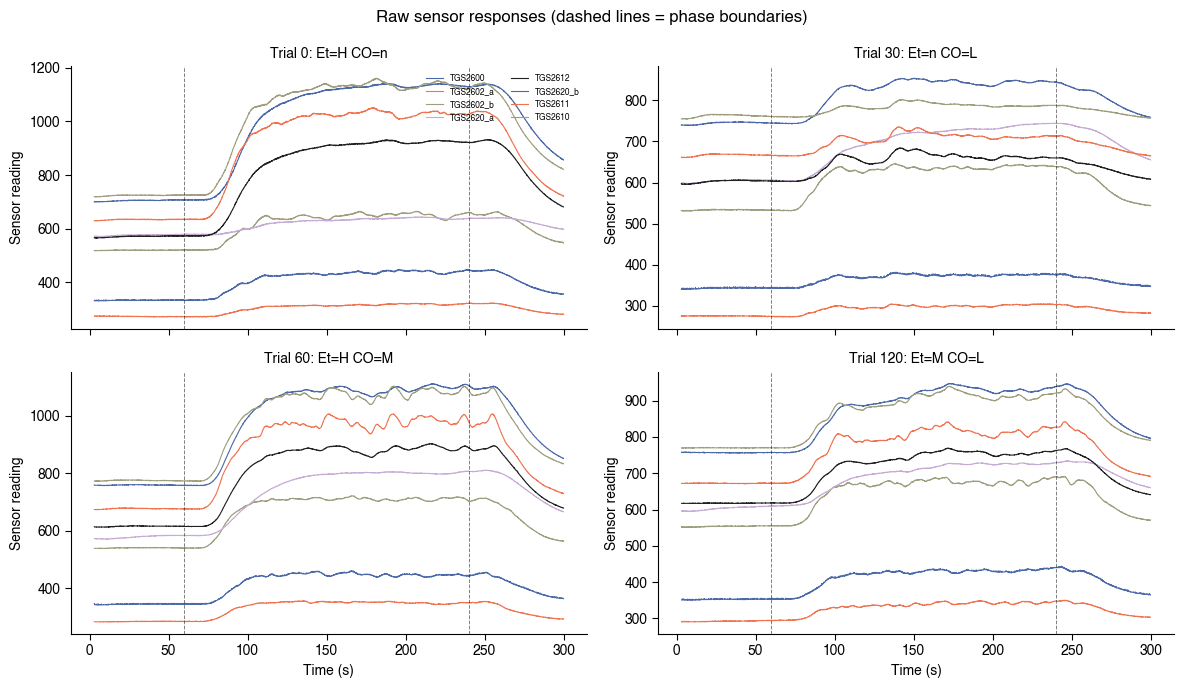

In [4]:
# Pick 4 example trials with different gas configs
examples = [trials[0], trials[30], trials[60], trials[120]]

fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)
for ax, trial in zip(axes.flat, examples):
    t = trial['data'][:, 0]
    for j, name in enumerate(SENSOR_NAMES):
        ax.plot(t, trial['data'][:, 3 + j], lw=0.8, label=name)
    ax.axvline(60, color='k', ls='--', lw=0.7, alpha=0.5)
    ax.axvline(240, color='k', ls='--', lw=0.7, alpha=0.5)
    ax.set_title(f"Trial {trial['id']}: Et={trial['et_level']} {trial['gas2']}={trial['gas2_level']}", fontsize=10)
    ax.set_ylabel('Sensor reading')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 1].set_xlabel('Time (s)')
axes[0, 0].legend(fontsize=6, ncol=2, loc='upper right')
fig.suptitle('Raw sensor responses (dashed lines = phase boundaries)', fontsize=12)
plt.tight_layout()
plt.show()

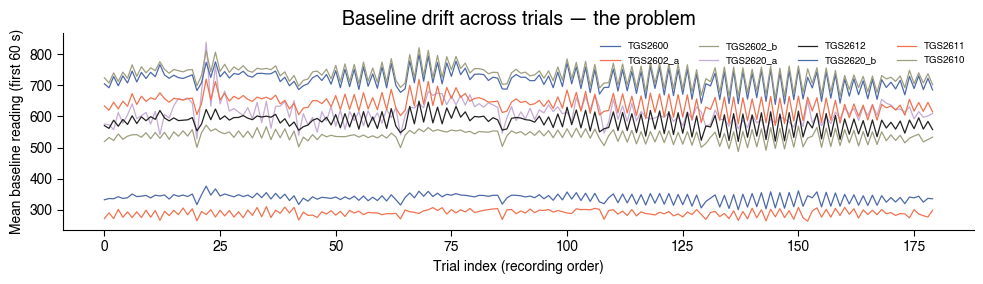

In [5]:
# Show baseline drift: mean of sensor 0 (TGS2600) during first 60 s, for each trial in order
baseline_means = []
for trial in trials:
    mask = trial['data'][:, 0] < 60.0
    baseline_means.append(trial['data'][mask, 3:].mean(axis=0))  # (8,) per trial
baseline_means = np.array(baseline_means)  # (180, 8)

fig, ax = plt.subplots(figsize=(10, 3))
for j in range(baseline_means.shape[1]):
    ax.plot(baseline_means[:, j], lw=0.9, label=SENSOR_NAMES[j])
ax.set_xlabel('Trial index (recording order)')
ax.set_ylabel('Mean baseline reading (first 60 s)')
ax.set_title('Baseline drift across trials — the problem')
ax.legend(fontsize=7, ncol=4)
plt.tight_layout()
plt.show()

## 4. Apply zero-offset baseline correction

For each trial, subtract the mean sensor value during the 60 s baseline (clean air) from all timepoints.

In [6]:
for trial in trials:
    baseline_mask = trial['data'][:, 0] < 60.0
    baseline_mean = trial['data'][baseline_mask, 3:].mean(axis=0)  # shape (8,)
    corrected = trial['data'].copy()
    corrected[:, 3:] -= baseline_mean
    trial['data_corrected'] = corrected
    trial['baseline_mean'] = baseline_mean

print(f'Baseline correction applied to {len(trials)} trials.')

Baseline correction applied to 180 trials.


## 5. Visualize corrected data

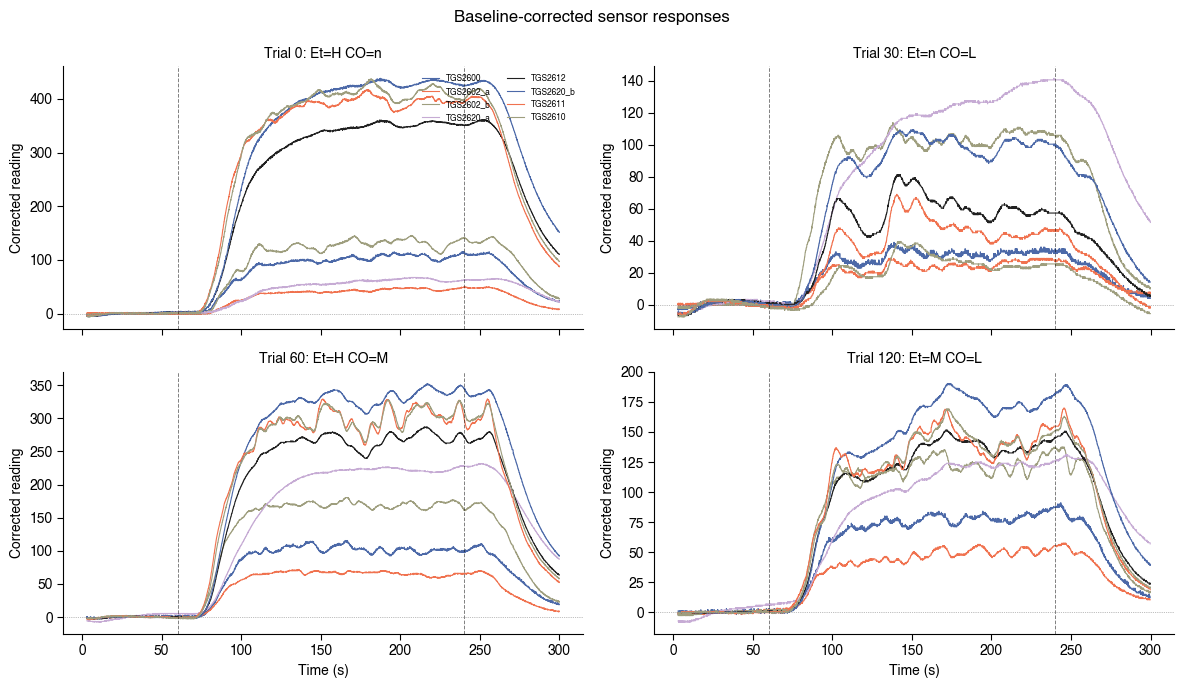

In [7]:
# Same 4 example trials, now baseline-corrected
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)
for ax, trial in zip(axes.flat, examples):
    t = trial['data_corrected'][:, 0]
    for j, name in enumerate(SENSOR_NAMES):
        ax.plot(t, trial['data_corrected'][:, 3 + j], lw=0.8, label=name)
    ax.axvline(60, color='k', ls='--', lw=0.7, alpha=0.5)
    ax.axvline(240, color='k', ls='--', lw=0.7, alpha=0.5)
    ax.axhline(0, color='gray', ls=':', lw=0.5)
    ax.set_title(f"Trial {trial['id']}: Et={trial['et_level']} {trial['gas2']}={trial['gas2_level']}", fontsize=10)
    ax.set_ylabel('Corrected reading')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 1].set_xlabel('Time (s)')
axes[0, 0].legend(fontsize=6, ncol=2, loc='upper right')
fig.suptitle('Baseline-corrected sensor responses', fontsize=12)
plt.tight_layout()
plt.show()

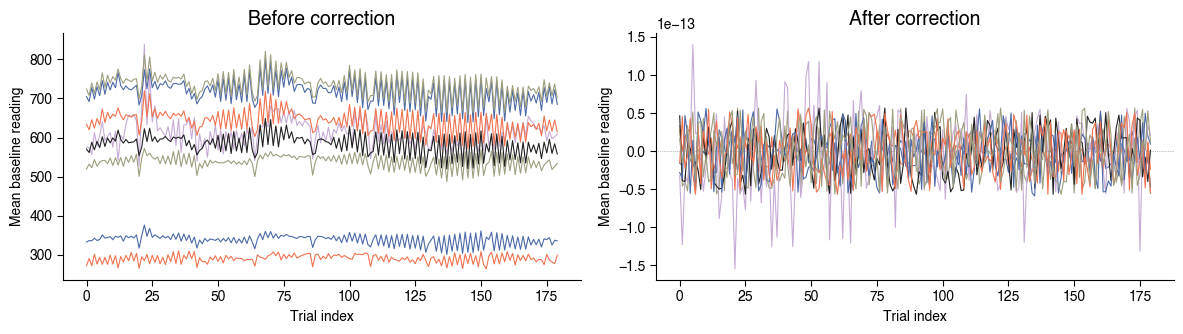

Baseline std before correction:  26.11
Baseline std after correction:   0.0000


In [8]:
# Before vs after: baseline means across all trials
baseline_means_corrected = []
for trial in trials:
    mask = trial['data_corrected'][:, 0] < 60.0
    baseline_means_corrected.append(trial['data_corrected'][mask, 3:].mean(axis=0))
baseline_means_corrected = np.array(baseline_means_corrected)

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=False)

ax = axes[0]
for j in range(baseline_means.shape[1]):
    ax.plot(baseline_means[:, j], lw=0.8)
ax.set_title('Before correction')
ax.set_xlabel('Trial index')
ax.set_ylabel('Mean baseline reading')

ax = axes[1]
for j in range(baseline_means_corrected.shape[1]):
    ax.plot(baseline_means_corrected[:, j], lw=0.8)
ax.set_title('After correction')
ax.set_xlabel('Trial index')
ax.set_ylabel('Mean baseline reading')
ax.axhline(0, color='gray', ls=':', lw=0.5)

plt.tight_layout()
plt.show()

print(f'Baseline std before correction:  {baseline_means.std(axis=0).mean():.2f}')
print(f'Baseline std after correction:   {baseline_means_corrected.std(axis=0).mean():.4f}')

## 6. Save corrected dataset

In [9]:
save_path = 'data/fonollosa_corrected.pkl'
pickle.dump(trials, open(save_path, 'wb'))
print(f'Saved {len(trials)} trials to {save_path}')

Saved 180 trials to data/fonollosa_corrected.pkl
